**You may need to install [OpenCV](https://pypi.python.org/pypi/opencv-python) and [scikit-video](http://www.scikit-video.org/stable/).**

In [4]:
import keras
import numpy as np
import io
import base64
from IPython.display import HTML
import skvideo.io
import cv2
import json
import random 
import matplotlib.pyplot as plt

from keras.models import Sequential,model_from_json
from keras.layers.core import Dense, Flatten
from keras.optimizers import sgd
from keras.layers import Conv2D, MaxPooling2D, Activation, AveragePooling2D,Reshape,BatchNormalization

import warnings
warnings.simplefilter('ignore')

Using TensorFlow backend.


# MiniProject on Deep Reinforcement Learning

__Notations__: $E_p$ is the expectation under probability $p$. Please justify each of your answer and widely comment your code.

# Context

In a reinforcement learning algorithm, we modelize each step $t$ as an action $a_t$ obtained from a state $s_t$, i.e. $\{(a_{t},s_{t})_{t\leq T}\}$ having the Markov property. We consider a discount factor $\gamma \in [0,1]$ that ensures convergence. The goal is to find among all the policies $\pi$, one that maximizes the expected reward:

\begin{equation*}
R(\pi)=\sum_{t\leq T}E_{p^{\pi}}[\gamma^t r(s_{t},a_{t})] \> ,
\end{equation*}

where: 
\begin{equation*}p^{\pi}(a_{0},a_{1},s_{1},...,a_{T},s_{T})=p(a_{0})\prod_{t=1}^{T}\pi(a_{t}|s_{t})p(s_{t+1}|s_{t},a_{t}) \> .
\end{equation*}

We note the $Q$-function:

\begin{equation*}Q^\pi(s,a)=E_{p^{\pi}}[\sum_{t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] \> .
\end{equation*}

Thus, the optimal Q function is:
\begin{equation*}
Q^*(s,a)=\max_{\pi}Q^\pi(s,a) \> .
\end{equation*}

In this project, we will apply the deep reinforcement learning techniques to a simple game: an agent will have to learn from scratch a policy that will permit it maximizing a reward.

## The environment, the agent and the game

### The environment

```Environment``` is an abstract class that represents the states, rewards, and actions to obtain the new state.

In [ ]:
class Environment(object):
    def __init__(self):
        pass

    def act(self, act):
        """
        One can act on the environment and obtain its reaction:
        - the new state
        - the reward of the new state
        - should we continue the game?

        :return: state, reward, game_over
        """
        pass


    def reset(self):
        """
        Reinitialize the environment to a random state and returns
        the original state

        :return: state
        """
        pass
    
    def draw(self):
        """
        Visualize in the console or graphically the current state
        """
        pass

The method ```act``` allows to act on the environment at a given state $s_t$ (stored internally), via action $a_t$. The method will return the new state $s_{t+1}$, the reward $r(s_{t},a_{t})$ and determines if $t\leq T$ (*game_over*).

The method ```reset``` simply reinitializes the environment to a random state $s_0$.

The method ```draw``` displays the current state $s_t$ (this is useful to check the behavior of the Agent).

We modelize $s_t$ as a tensor, while $a_t$ is an integer.

### The Agent

The goal of the ```Agent``` is to interact with the ```Environment``` by proposing actions $a_t$ obtained from a given state $s_t$ to attempt to maximize its __reward__ $r(s_t,a_t)$. We propose the following abstract class:

In [ ]:
class Agent(object):
    def __init__(self, epsilon=0.1, n_action=4):
        self.epsilon = epsilon
        self.n_action = n_action
    
    def set_epsilon(self,e):
        self.epsilon = e

    def act(self,s,train=True):
        """ This function should return the next action to do:
        an integer between 0 and 4 (not included) with a random exploration of epsilon"""
        if train:
            if np.random.rand() <= self.epsilon:
                a = np.random.randint(0, self.n_action, size=1)[0]
            else:
                a = self.learned_act(s)
        else: # in some cases, this can improve the performance.. remove it if poor performances
            a = self.learned_act(s)

        return a

    def learned_act(self,s):
        """ Act via the policy of the agent, from a given state s
        it proposes an action a"""
        pass

    def reinforce(self, s, n_s, a, r, game_over_):
        """ This function is the core of the learning algorithm. 
        It takes as an input the current state s_, the next state n_s_
        the action a_ used to move from s_ to n_s_ and the reward r_.
        
        Its goal is to learn a policy.
        """
        pass

    def save(self):
        """ This function returns basic stats if applicable: the
        loss and/or the model"""
        pass

    def load(self):
        """ This function allows to restore a model"""
        pass

***
__Question 1__:
Explain the function act. Why is ```epsilon``` essential?

**Answer** 

The function ```act``` proceeds to an $\varepsilon$-greedy choice of action. 
It goes as follows: 
- with probability $1-\varepsilon$, select learned_act (ie the optimal action according to the current estimations)
- with probability $\varepsilon$, select the action to take uniformly over the set of actions. 

This allows for exploration of all actions (if ```epsilon``` is high enough), while making sure that we do not choose actions which may be suboptimal too often.

It is a simple way to tackle the exploration-exploitation dilemma.

***
### The Game

The ```Agent``` and the ```Environment``` work in an interlaced way as in the following (take some time to understand this code as it is the core of the project)

```python

epoch = 300
env = Environment()
agent = Agent()


# Number of won games
score = 0
loss = 0


for e in range(epoch):
    # At each epoch, we restart to a fresh game and get the initial state
    state = env.reset()
    # This assumes that the games will end
    game_over = False

    win = 0
    lose = 0
    
    while not game_over:
        # The agent performs an action
        action = agent.act(state)

        # Apply an action to the environment, get the next state, the reward
        # and if the games end
        prev_state = state
        state, reward, game_over = env.act(action)

        # Update the counters
        if reward > 0:
            win = win + reward
        if reward < 0:
            lose = lose -reward

        # Apply the reinforcement strategy
        loss = agent.reinforce(prev_state, state,  action, reward, game_over)

    # Save as a mp4
    if e % 10 == 0:
        env.draw(e)

    # Update stats
    score += win-lose

    print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
          .format(e, epoch, loss, win, lose, win-lose))
    agent.save()
```

# The game, *eat cheese*

A rat runs on an island and tries to eat as much as possible. The island is subdivided into $N\times N$ cells, in which there are cheese (+0.5) and poisonous cells (-1). The rat has a visibility of 2 cells (thus it can see $5^2$ cells). The rat is given a time $T$ to accumulate as much food as possible. It can perform 4 actions: going up, down, left, right. 

The goal is to code an agent to solve this task that will learn by trial and error. We propose the following environment:

In [ ]:
class Environment(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))

        # coordinate of the rat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))


    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board>0,0] = 256
        b[self.board < 0, 2] = 256
        b[self.x,self.y,:]=256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b


    def act(self, action):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[:, -2:] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        reward = self.board[self.x, self.y]
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        state = np.concatenate((self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[:, -2:] = -1
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((
                               self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

The following elements are important because they correspond to the hyper parameters for this project:

In [ ]:
# parameters
size = 13
T=200
temperature=0.3
epochs_train=10 # set small when debugging
epochs_test=10 # set small when debugging

# display videos
def display_videos(name):
    video = io.open(name, 'r+b').read()
    encoded = base64.b64encode(video)
    return '''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))

__Question 2__ Explain the use of the arrays ```position``` and ```board```.

**Answer**

The ```board``` array is a matrix which represents the physical environment. Each element of the matrix corresponds to a cell in the problem, and may have positive reward (or bonus) or a negative reward (or malus), according to whether there is cheese or poison on the cell, or no reward at all if there is nothing on the cell. 

The ```position``` array has the same shape as the ```board``` array. It represents the positions where the rat is with a 1. It helps to define the state, since it gives the position of the visible cells from the rat's position.



## Random Agent

***
__Question 3__ Implement a random Agent (only ```learned_act``` needs to be implemented):

This is a random agent, so that there is no proper learning: it selects its action randomly.

In [ ]:
class RandomAgent(Agent):
    def __init__(self):
        super(RandomAgent, self).__init__()
        pass

    def learned_act(self, s):
        """
        returns random action
        """
        action = np.random.randint(4)
        return action

***
***
__Question 4__ Visualize the game moves. You need to fill in the following function for the evaluation:

In [ ]:
def test(agent,env,epochs,prefix=''):
    # Number of won games
    score = 0
        
    for e in range(1,epochs+1):
        
        state = env.reset()
        game_over = False
        win = 0
        lose = 0
        while not game_over and env.t<T:
            action = agent.act(state,train=False)
            state,reward,game_over = env.act(action)
            if reward >=0: 
                win += reward
            else: 
                lose -= reward 
        
        # Save as a mp4
        env.draw(prefix+str(e))

        # Update stats
        score = score + win-lose
        if e%10 == 0:
            print("Win/lose count {}/{}. Average score ({})"
                  .format(win, lose, score/e))
    print('Final score: '+str(score/epochs))

In [10]:
# Initialize the game
env = Environment(grid_size=size, max_time=T,temperature=temperature)

# Initialize the agent!
agent = RandomAgent()

test(agent,env,epochs_test,prefix='random')
HTML(display_videos('random10.mp4'))

Win/lose count 7.5/9.0. Average score (-3.5)
Final score: -3.5


***
## DQN

Let us assume here that $T=\infty$.

***
__Question 5__ Let $\pi$ be a policy, show that:

\begin{equation*}
Q^{\pi}(s,a)=E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{equation*}

Then, show that for the optimal policy $\pi^*$ (we assume its existence), the following holds: 

\begin{equation*}
Q^{*}(s,a)=E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')].
\end{equation*}
Finally, deduce that a plausible objective is:

\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma\max\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}.
\end{equation*}




**Answer**

We have 

\begin{equation}
\begin{split}
Q^\pi(s,a)
&=E_{p^{\pi}}[\sum_{t=0}^{\infty}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] \\
&= \gamma^0 r(s,a)+ \sum_{s',a'} p(s'|s,a)E_{p^{\pi}} [\sum_{t=1}^ {\infty}\gamma^{t}r(s_{t},a_{t})|s_{1}=s',a_{1}=a'] \\
&= r(s,a) + \gamma \sum_{s',a'} p(s'|s,a)E_{p^{\pi}} [\sum_{t=0}^ {\infty}\gamma^{t}r(s_{t},a_{t})|s_{0}=s',a_{0}=a'] \\
&= r(s,a) + \gamma E_{p^{\pi}} Q^\pi(s',a') \\
&= E_{p^{\pi}}[r(s,a) + \gamma Q^\pi(s',a')]
\end{split}
\end{equation}

Moreover, $Q^*(s,a) = \underset{\pi}{max} Q^{\pi}(s,a)$

Using the previous result, taking the max on $\pi$, it comes that 
$$
\max_{\pi} Q^{\pi}(s,a)=E_{s'\sim p(.|s,a)}[r(s,a)+\gamma\max_{\pi}Q^{\pi}(s',a')].
$$
which gives us the desired result.

From this, we want for our $Q$
$$
E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q(s',a',\theta)]-Q(s,a,\theta) = E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)]
$$

to be as close as possible to 0. 
With Jensen inequality, 
$$
E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)]^2 
\leq
E_{s'\sim \pi^*(.|s,a)}[||r(s,a)+\gamma\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)||^2] 
$$
And it is easy to compute an empirical estimate of this final term, so that we can define $\mathcal{L}(\theta)$ a such.




***
The DQN-learning algorithm relies on these derivations to train the parameters $\theta$ of a Deep Neural Network:

1. At the state $s_t$, select the action $a_t$ with best reward using $Q_t$ and store the results;

2. Obtain the new state $s_{t+1}$ from the environment $p$;

3. Store $(s_t,a_t,s_{t+1})$;

4. Obtain $Q_{t+1}$ by minimizing  $\mathcal{L}$ from a recovered batch from the previously stored results.

***
__Question 6__ Implement the class ```Memory``` that stores moves (in a replay buffer) via ```remember``` and provides a ```random_access``` to these. Specify a maximum memory size to avoid side effects. You can for example use a ```list()``` and set by default ```max_memory=100```.

In [ ]:
class Memory(object):
    def __init__(self, max_memory=100):
        self.max_memory = max_memory
        self.memory = list()

    def remember(self, m):
        """
        if the memory is not full, adds the episode.
        Otherwise, deletes the most ancient episode in memory and add the new episode
        """
        if len(self.memory)<self.max_memory:
            self.memory.append(m[:])
        else: 
            self.memory.pop(0) #remove most ancient transition in the memory 
            self.memory.append(m[:])

    def random_access(self):
        #return random samples from the memory
        return random.sample(self.memory,1)[0]

***
The pipeline we will use for training is given below:

In [ ]:
def train(agent,env,epoch,prefix=''):
    # Number of won games
    score = 0
    loss = 0
    scores = [] #for plotting
    losses = [] #for plotting
    for e in range(1,epoch+1):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))
            
        # Update stats
        score = win-lose
        scores.append(score)
        losses.append(loss)
        if e%10==0:
            print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
                  .format(e, epoch, loss, win, lose, win-lose))
            
    agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')

    #plotting
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
    ax1.plot(scores,c='g')
    ax1.set_title('Evolution of score')
    ax1.set_ylabel('Score')
    ax1.set_xlabel('Epoch')

    ax2.plot(losses,c='b')
    ax2.set_title('Evolution of loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')

***
__Question 7__ Implement the DQN training algorithm using a cascade of fully connected layers. You can use different learning rate, batch size or memory size parameters. In particular, the loss might oscillate while the player will start to win the games. You have to find a good criterium.

In [ ]:
class DQN(Agent):
    def __init__(self, grid_size,  epsilon = 0.1, memory_size=100, batch_size = 16,n_state=2):
        super(DQN, self).__init__(epsilon = epsilon)

        # Discount for Q learning
        self.discount = 0.99
        
        self.grid_size = grid_size
        
        # number of states
        self.n_state = n_state

        # Memory
        self.memory = Memory(memory_size)
        
        # Batch size when learning
        self.batch_size = batch_size

    def learned_act(self, s):
        #greedy estimation of the best action
        return np.argmax(self.model.predict(s.reshape(1,5,5,self.n_state)))

    def reinforce(self, s_, n_s_, a_, r_, game_over_):
        # Two steps: first memorize the states, second learn from the pool

        self.memory.remember([s_, n_s_, a_, r_, game_over_])
        
        input_states = np.zeros((self.batch_size, 5,5,self.n_state))
        target_q = np.zeros((self.batch_size, 4))
        
        for i in range(self.batch_size):
            
            s,ns,a,r,game_over = self.memory.random_access()
            target_q[i] = self.model.predict(s.reshape(1,5,5,self.n_state))
            if game_over_: #no next state 
                target_q[i][a] = r
                
            else:
                #give the right shape for prediction
                ns = ns.reshape(1,5,5,self.n_state)
                pred = self.model.predict(ns)
               
                Q_future = max(pred[0])
                target_q[i][a] = r + Q_future * self.discount

            input_states[i] = s
        
        # HINT: Clip the target to avoid exploiding gradients.. -- clipping is a bit tighter
        target_q = np.clip(target_q, -3, 3)

        l = self.model.train_on_batch(input_states, target_q)
        
        return l

    def save(self,name_weights='model.h5',name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self,name_weights='model.h5',name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        model.compile("sgd", "mse")
        self.model = model

            
class DQN_FC(DQN):
    def __init__(self, *args, lr=0.1,**kwargs):
        super(DQN_FC, self).__init__( *args,**kwargs)
        
        #simple fully connected model
        model   = Sequential()
        model.add(Flatten())
        model.add(Dense(24, input_dim=5*5*self.n_state, activation="relu"))
        model.add(Dense(24, activation="relu"))
        model.add(Dense(self.n_action))
        
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model
        

Epoch 010/100 | Loss 0.1326 | Win/lose count 2.5/7.0 (-4.5)
Epoch 020/100 | Loss 1.7657 | Win/lose count 4.0/1.0 (3.0)
Epoch 030/100 | Loss 1.8597 | Win/lose count 2.0/2.0 (0.0)
Epoch 040/100 | Loss 1.6752 | Win/lose count 5.0/4.0 (1.0)
Epoch 050/100 | Loss 1.6980 | Win/lose count 4.0/4.0 (0.0)
Epoch 060/100 | Loss 1.7840 | Win/lose count 16.0/7.0 (9.0)
Epoch 070/100 | Loss 1.6748 | Win/lose count 3.0/2.0 (1.0)
Epoch 080/100 | Loss 1.6523 | Win/lose count 11.5/2.0 (9.5)
Epoch 090/100 | Loss 1.6701 | Win/lose count 9.0/2.0 (7.0)
Epoch 100/100 | Loss 1.8228 | Win/lose count 9.0/2.0 (7.0)


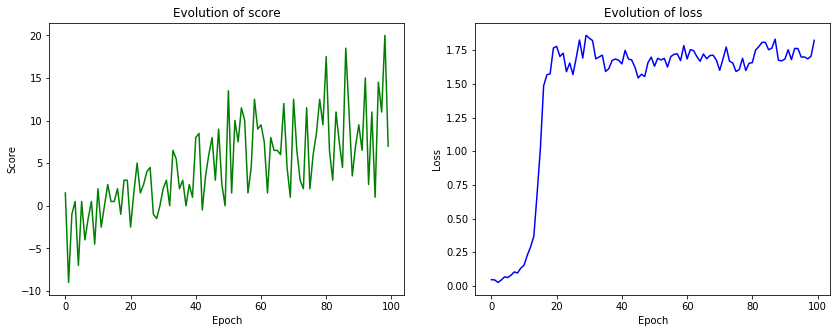

In [38]:
epochs_train = 100
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_FC(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
train(agent, env, epochs_train, prefix='fc_train')
HTML(display_videos('fc_train'+str(epochs_train)+'.mp4'))

The loss does not evolve much after the first few epochs, but the score improves (even if it has a large variance).

***
***
__Question 8__ Implement the DQN training algorithm using a CNN (for example, 2 convolutional layers and one final fully connected layer).

In [ ]:
class DQN_CNN(DQN):
    def __init__(self, *args,lr=0.1,**kwargs):
        super(DQN_CNN, self).__init__(*args,**kwargs)
        
        #simple convolutional model
        model = Sequential()
        model.add(Conv2D(9,3,activation='relu'))
        model.add(Conv2D(9,3,activation='relu'))
        model.add(Flatten())
        model.add(Dense(self.n_action))
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model













Epoch 010/100 | Loss 1.8206 | Win/lose count 5.5/1.0 (4.5)
Epoch 020/100 | Loss 1.8355 | Win/lose count 12.0/1.0 (11.0)
Epoch 030/100 | Loss 1.6890 | Win/lose count 5.5/0 (5.5)
Epoch 040/100 | Loss 1.5872 | Win/lose count 6.0/1.0 (5.0)
Epoch 050/100 | Loss 1.7179 | Win/lose count 10.5/0 (10.5)
Epoch 060/100 | Loss 1.6172 | Win/lose count 16.0/5.0 (11.0)
Epoch 070/100 | Loss 1.6988 | Win/lose count 16.5/1.0 (15.5)
Epoch 080/100 | Loss 1.7180 | Win/lose count 24.0/7.0 (17.0)
Epoch 090/100 | Loss 1.6972 | Win/lose count 9.5/2.0 (7.5)
Epoch 100/100 | Loss 1.7146 | Win/lose count 12.0/4.0 (8.0)


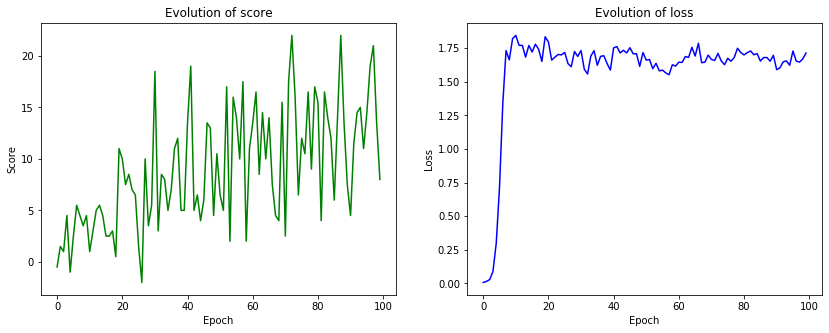

In [15]:
epochs_train = 100
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
train(agent,env,epochs_train,prefix='cnn_train')
HTML(display_videos('cnn_train'+str(epochs_train)+'.mp4'))

The training is similar to the one of the fully connected network: the loss does not decrease very much while the score keeps improving, with a large variance.

***
***
__Question 9__ Test both algorithms and compare their performances. Which issue(s) do you observe? Observe also different behaviors by changing the temperature.

In [39]:
epochs_test = 10
env = Environment(grid_size=size, max_time=T,temperature=0.3)
agent_cnn = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='cnn_trainmodel.h5',name_model='cnn_trainmodel.json')

agent_fc = DQN_FC(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='fc_trainmodel.h5',name_model='fc_trainmodel.json')
print('Test of the CNN')
test(agent_cnn,env,epochs_test,prefix='cnn_test')
print('Test of the FC')
test(agent_fc,env,epochs_test,prefix='fc_test')

Test of the CNN
Win/lose count 1.5/0. Average score (5.45)
Final score: 5.45
Test of the FC
Win/lose count 0.5/0. Average score (0.15)
Final score: 0.15


In [40]:
HTML(display_videos('cnn_test'+str(epochs_test)+'.mp4'))

In [42]:
HTML(display_videos('fc_test'+str(epochs_test)+'.mp4'))

**Observations**

CNN are translation invariant, which is relevant in our situation because wherever the rat is on the grid, its behaviour should only depend on the immediate environment. 

On the other hand, FC layers are sensitive to the specification of the grid and prove less efficient.

In both cases, increasing the temperature increases the score.

However, there seem to be a lack of exploration, probably due to the fact that our $\varepsilon$ is too low. This translates in oscillating movements (the rat being "stuck" between two or three cells). Also, once it does not see cheese anymore, it remains on known cells, which prevents it from eating poison.

***

The algorithm tends to not explore the map which can be an issue. We propose two ideas in order to encourage exploration:
1. Incorporating a decreasing $\epsilon$-greedy exploration. You can use the method ```set_epsilon```
2. Append via the environment a new state that describes if a cell has been visited or not

***
__Question 10__ Design a new ```train_explore``` function and environment class ```EnvironmentExploring``` to tackle the issue of exploration.



In [ ]:
def train_explore(agent,env,epoch,prefix=''):
    # Number of won games
    score = 0
    loss = 0
    scores = []
    losses = []
    for e in range(1,epoch+1):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action in training mode
            action = agent.act(state,train=True)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)
        agent.set_epsilon(agent.epsilon*0.95)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))
            
        # Update stats
        score = win-lose
        scores.append(score)
        losses.append(loss)
        if e%10==0:
            print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
                  .format(e, epoch, loss, win, lose, win-lose))
        
    agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
    ax1.plot(scores,c='g')
    ax1.set_title('Evolution of score')
    ax1.set_ylabel('Score')
    ax1.set_xlabel('Epoch')

    ax2.plot(losses,c='b')
    ax2.set_title('Evolution of loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
        
class EnvironmentExploring(object):    
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))

        # coordinate of the rat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))
        
        self.malus_position = np.zeros((grid_size,grid_size))

    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board>0,0] = 256
        b[self.board < 0, 2] = 256
        b[self.x,self.y,:]=256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b


    def act(self, action,train=False):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        #penalize the exploration of already explored positions
        reward = 0
        if train:
            reward = -self.malus_position[self.x, self.y]
        self.malus_position[self.x, self.y] = 2. #we boosted the malus compared to what was proposed
        reward = reward + self.board[self.x, self.y]
        
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        
        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                               self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

Epoch 010/200 | Loss 1.9028 | Win/lose count 12.0/17.0 (-5.0)
Epoch 020/200 | Loss 2.0649 | Win/lose count 8.5/7.0 (1.5)
Epoch 030/200 | Loss 1.8916 | Win/lose count 13.5/2.0 (11.5)
Epoch 040/200 | Loss 1.8408 | Win/lose count 20.5/4.0 (16.5)
Epoch 050/200 | Loss 1.6982 | Win/lose count 8.5/2.0 (6.5)
Epoch 060/200 | Loss 1.8045 | Win/lose count 8.0/0 (8.0)
Epoch 070/200 | Loss 1.7251 | Win/lose count 8.0/0 (8.0)
Epoch 080/200 | Loss 1.6968 | Win/lose count 4.0/0 (4.0)
Epoch 090/200 | Loss 1.8070 | Win/lose count 12.0/1.0 (11.0)
Epoch 100/200 | Loss 1.7626 | Win/lose count 2.5/0 (2.5)
Epoch 110/200 | Loss 1.7210 | Win/lose count 6.5/0 (6.5)
Epoch 120/200 | Loss 1.7361 | Win/lose count 10.5/0 (10.5)
Epoch 130/200 | Loss 1.6557 | Win/lose count 5.0/1.0 (4.0)
Epoch 140/200 | Loss 1.6712 | Win/lose count 22.5/1.0 (21.5)
Epoch 150/200 | Loss 1.6838 | Win/lose count 15.5/1.0 (14.5)
Epoch 160/200 | Loss 1.4339 | Win/lose count 3.5/0 (3.5)
Epoch 170/200 | Loss 1.6827 | Win/lose count 17.5/0 (17

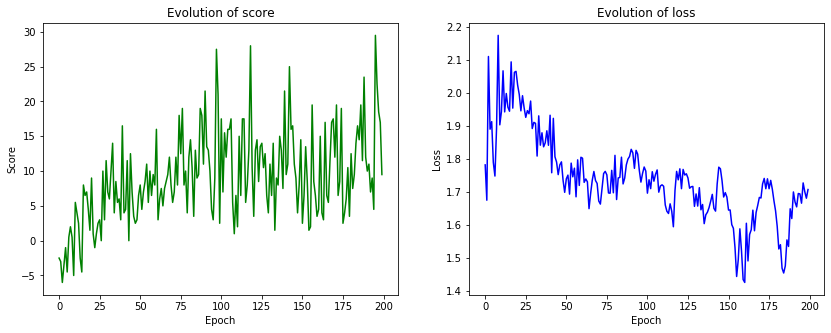

In [34]:
# Training
epochs_train = 200
env = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=.1, epsilon = 0.9, memory_size=2000, batch_size = 32,n_state=3)
train_explore(agent, env, epochs_train, prefix='cnn_train_explore')
HTML(display_videos('cnn_train_explore'+str(epochs_train)+'.mp4'))

In [37]:
# Evaluation
epochs_test = 10
test(agent,env,epochs_test,prefix='cnn_test_explore')
HTML(display_videos('cnn_test_explore'+str(epochs_test)+'.mp4'))

Win/lose count 13.5/0. Average score (12.8)
Final score: 12.8


Our model, despite the malus trick, keeps getting stuck in some place after having explored approximately half the grid (ie, once it does not see cheese anymore). However, it overall behaves in a way more relevant manner than the previous models. Also, the loss has the expected non increasing behaviour.

***
***
__BONUS question__ Use the expert DQN from the previous question to generate some winning games. Train a model that mimicks its behavior. Compare the performances.

***